alpha: 1.5, True model ATE 1.5091971158981323


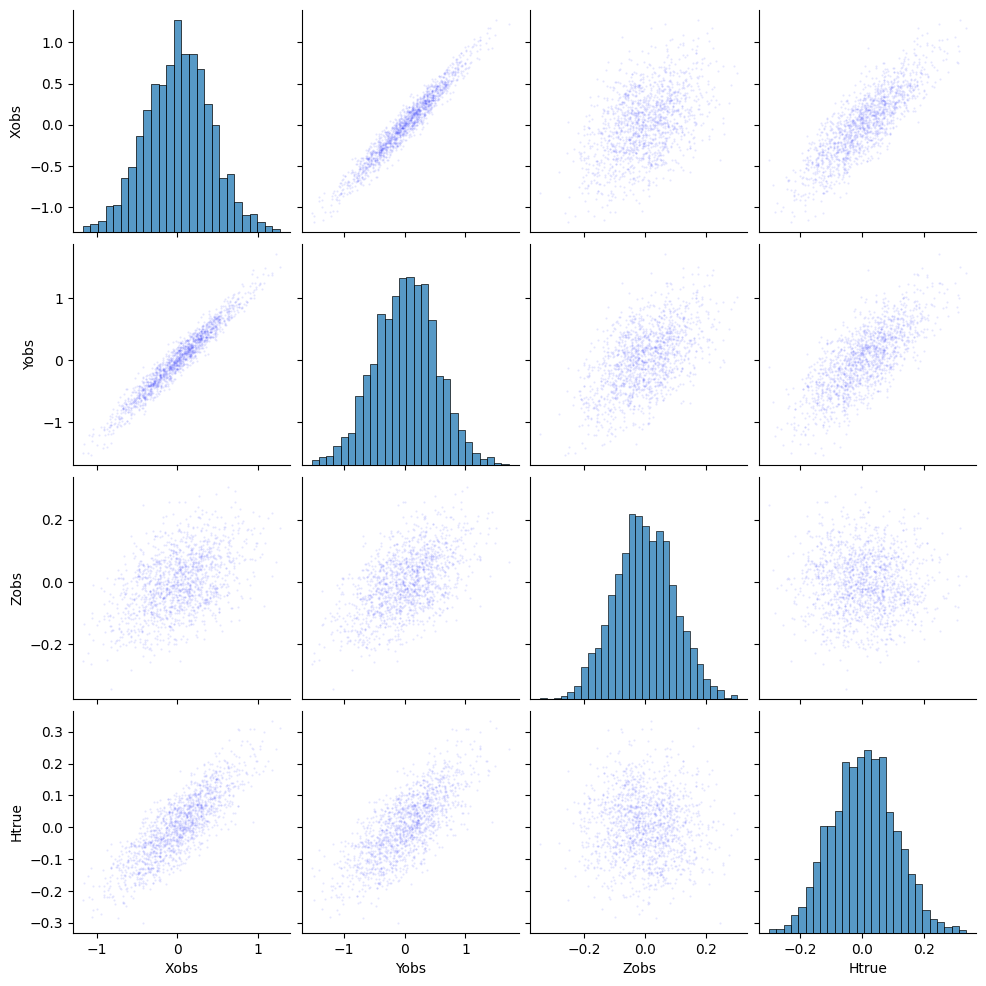

loss=-1931.6168212890625: 100%|██████████| 3000/3000 [00:14<00:00, 205.72it/s]


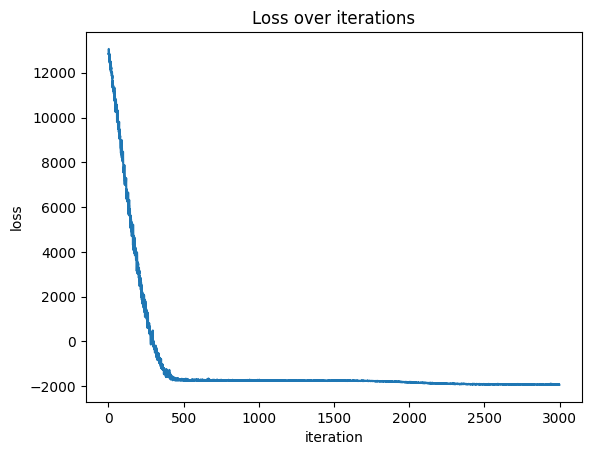

In [9]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import functools
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 
from typing import Callable
from tqdm import tqdm

torch.set_default_device('cpu')
pyro.settings.set(module_local_params=True)

smoke_test = "CI" in os.environ

class BayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def gamma(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def delta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaH(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,15)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,15)
    
    @PyroSample
    def meanH(self):
        return dist.Normal(0,2)
    
    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        H = pyro.sample('H',dist.Normal(self.meanH, self.sigmaH))
        X = pyro.sample('X',dist.Normal(self.beta * Z + self.gamma * H, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * X + self.delta * H, self.sigmaY))
        return X,Y,Z
    
class GroundTruthModel(BayesianLinearGaussianSCM):
    def __init__(self, alpha, beta, gamma, delta, sigmaZ, sigmaH, sigmaX, sigmaY, meanH):
        super().__init__()
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._delta = delta
        self._sigmaZ = sigmaZ
        self._sigmaH = sigmaH
        self._sigmaX = sigmaX
        self._sigmaY = sigmaY
        self._meanH = meanH


    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def delta(self):
        return self._delta
    
    @property
    def sigmaZ(self):
        return self._sigmaZ
    
    @property
    def sigmaH(self):
        return self._sigmaH
    
    @property
    def sigmaX(self):
        return self._sigmaX
    
    @property
    def sigmaY(self):
        return self._sigmaY
    
    @property
    def meanH(self):
        return self._meanH
    
class LinearInstrumentalATE(torch.nn.Module):
    def __init__(self, causal_model : Callable, *, num_monte_carlo : int = 1000):
        super().__init__()
        self.model = causal_model
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(X=(torch.tensor(0.),torch.tensor(1.)))):
                    _, y_all,_ = self.model(*args, **kwargs)
                y_cf_1 = gather(y_all, IndexSet(X={2}), event_dim=0)
                y_cf_0 = gather(y_all, IndexSet(X={1}), event_dim=0)
        
        ate = (y_cf_1 - y_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        return pyro.deterministic("ATE", ate)
    
class ObservedBayesianLinearGaussianSCM(BayesianLinearGaussianSCM):
    def __init__(self, n : int):
        super().__init__()
        self.n = n

    def forward(self, X=None, Y=None, Z=None):
        self.alpha, self.beta, self.gamma, self.delta, self.sigmaZ, self.sigmaH, self.sigmaX, self.sigmaY, self.meanH
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", self.n, dim=-1):
                return super().forward()

true_alpha, true_beta, true_gamma, true_delta = torch.tensor(1.5), torch.tensor(2.0), torch.tensor(3.3), torch.tensor(-1.2)
true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY = torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1)
true_meanH = torch.tensor(0.0)

gt_model = GroundTruthModel(true_alpha, true_beta, true_gamma, true_delta, true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY, true_meanH)

num_samples = 1500

with pyro.plate('samples', num_samples,dim=-1):
    tr=pyro.poutine.trace(gt_model).get_trace()

x_obs,y_obs,z_obs,h_true=[tr.nodes[name]['value'] for name in ['X','Y','Z','H']]

print(f'alpha: {true_alpha}, True model ATE {LinearInstrumentalATE(gt_model)()}')

sns.pairplot(pd.DataFrame({'Xobs':x_obs,'Yobs':y_obs,'Zobs':z_obs, 'Htrue': h_true}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

num_iterations = 3000 if not smoke_test else 10

pyro.clear_param_store()

obs_model = ObservedBayesianLinearGaussianSCM(len(x_obs))
obs_guide = AutoNormal(obs_model)
# obs_guide = pyro.infer.autoguide.AutoMultivariateNormal(obs_model)

# svi = SVI(obs_model, obs_guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())
elbo = pyro.infer.Trace_ELBO()(obs_model, obs_guide)

elbo(X=x_obs,Y=y_obs,Z=z_obs)

adam = torch.optim.Adam(elbo.parameters(), lr=0.01)
losses = []
pbar = tqdm(range(num_iterations))
pbar.set_description(f'loss=Inf')
for j in pbar:
    adam.zero_grad()
    loss = elbo(X=x_obs,Y=y_obs,Z=z_obs)
    loss.backward()
    losses.append(loss.item())
    adam.step()
    if (j + 1) % 100 == 0:
        pbar.set_description(f'loss={loss.item()}')
    #     print("[iteration %04d] loss: %.4f" % (j + 1, loss))

# plot loss
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over iterations')
plt.show()


Predicted model ATE 1.4496458768844604


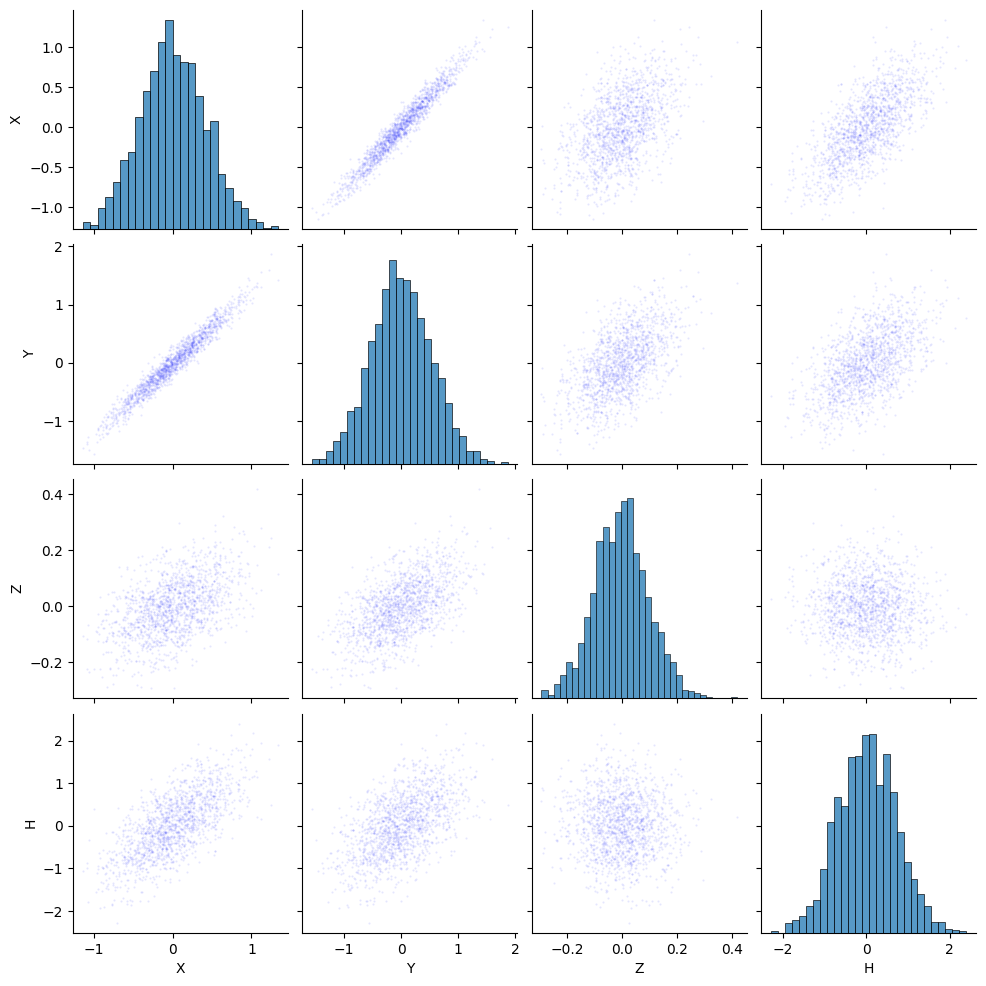

In [10]:
# x_pred,y_pred,z_pred=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()

predictive = PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)

tr=pyro.poutine.trace(predictive).get_trace()

ate_pred = LinearInstrumentalATE(PredictiveModel(ObservedBayesianLinearGaussianSCM(len(x_obs)), obs_guide), num_monte_carlo=1000)()
print(f'Predicted model ATE {ate_pred}')
x_pred,y_pred,z_pred,h_post=[tr.nodes[name]['value'] for name in ['X','Y','Z','H']]
sns.pairplot(pd.DataFrame({'X':x_pred.detach().numpy(),'Y':y_pred.detach().numpy(),'Z':z_pred.detach().numpy(),'H': h_post.detach().numpy()}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

Shapes Y: torch.Size([1, 1, 1, 5000, 1500]), torch.Size([1, 1, 1, 5000, 1500])
ate_direct=1.4494826793670654


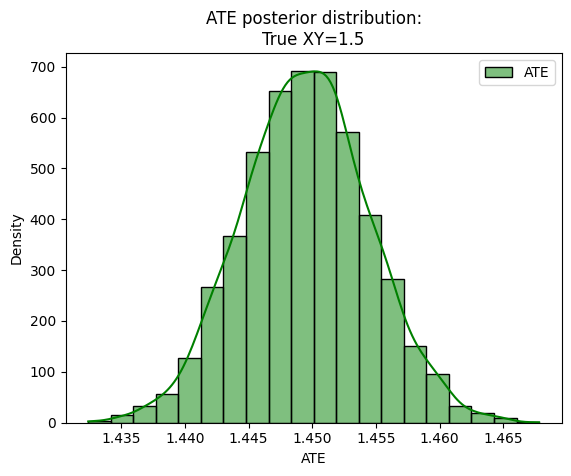

In [11]:
num_mc_samples = 5000
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    _,y_all,_ = predictive()
    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}')
plt.legend()
plt.show()

loss=111.22874450683594: 100%|██████████| 2000/2000 [00:05<00:00, 354.07it/s]


Shapes Y: torch.Size([5000, 1500]), torch.Size([5000, 1500])
ate_direct=0.0
Shapes Y: torch.Size([1, 1, 1, 5000, 1500]), torch.Size([1, 1, 1, 5000, 1500]), X: torch.Size([1, 1, 1, 5000, 1500]), torch.Size([1, 1, 1, 5000, 1500])
xz = 1.902308702468872, yz = 2.824618339538574, ate_2sls = 1.4848370552062988


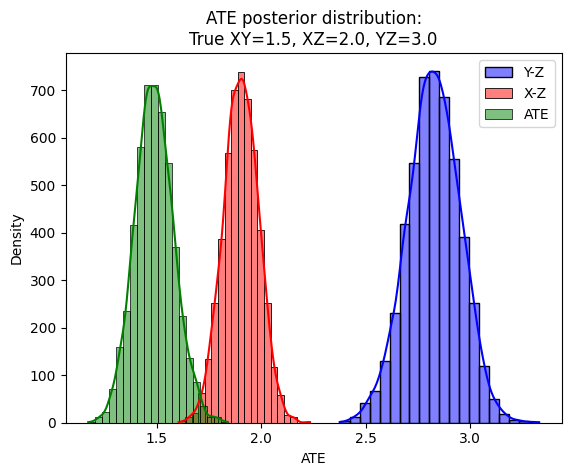

In [12]:
# create a reduced model, where we have Z,X,Y only with Gaussian distributions, such that X|Z ~ N(beta*Z, sigmaX), Y|Z ~ N(alpha*beta*Z, sigmaY)

class ReducedBayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,10)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)

    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        X = pyro.sample('X',dist.Normal(self.beta * Z, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * Z, self.sigmaY))
        return X,Y
    
class ReducedObservedBayesianLinearGaussianSCM(ReducedBayesianLinearGaussianSCM):
    def __init__(self, n):
        super().__init__()
        self.n = n
        
    def forward(self, X =None, Y=None,Z =None):
        self.alpha, self.beta, self.sigmaZ, self.sigmaX, self.sigmaY
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", self.n, dim=-1):
                return super().forward()
            
# Probabilistic inference for the reduced model
num_iterations = 2000 if not smoke_test else 10

pyro.clear_param_store()

obs_model_reduced = ReducedObservedBayesianLinearGaussianSCM(len(x_obs))
obs_guide_reduced = AutoNormal(obs_model_reduced)

elbo = pyro.infer.Trace_ELBO()(obs_model_reduced, obs_guide_reduced)

elbo(X=x_obs,Y=y_obs,Z=z_obs)

adam = torch.optim.Adam(elbo.parameters(), lr=0.03)
losses = []
pbar = tqdm(range(num_iterations))
pbar.set_description(f'loss=Inf')
for j in pbar:
    adam.zero_grad()
    loss = elbo(X=x_obs,Y=y_obs,Z=z_obs)
    loss.backward()
    losses.append(loss.item())
    adam.step()
    if (j + 1) % 50 == 0:
        pbar.set_description(f'loss={loss.item()}')


reduced_predictive = PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(ReducedBayesianLinearGaussianSCM()), obs_guide_reduced)


num_mc_samples = 5000
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all = reduced_predictive()
    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all = reduced_predictive()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
plt.show()



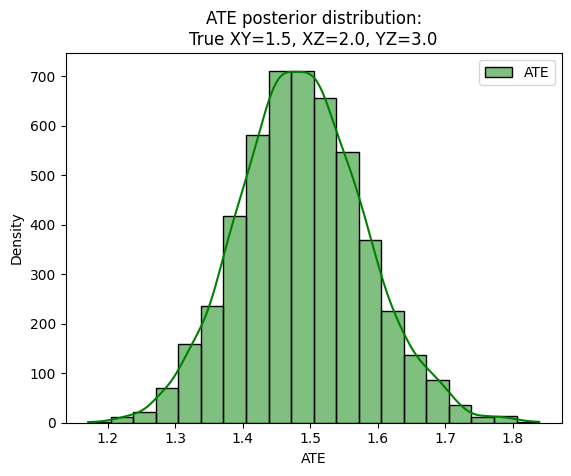

In [13]:
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
plt.show()

Predicted model ATE 2SLS 1.4838570356369019


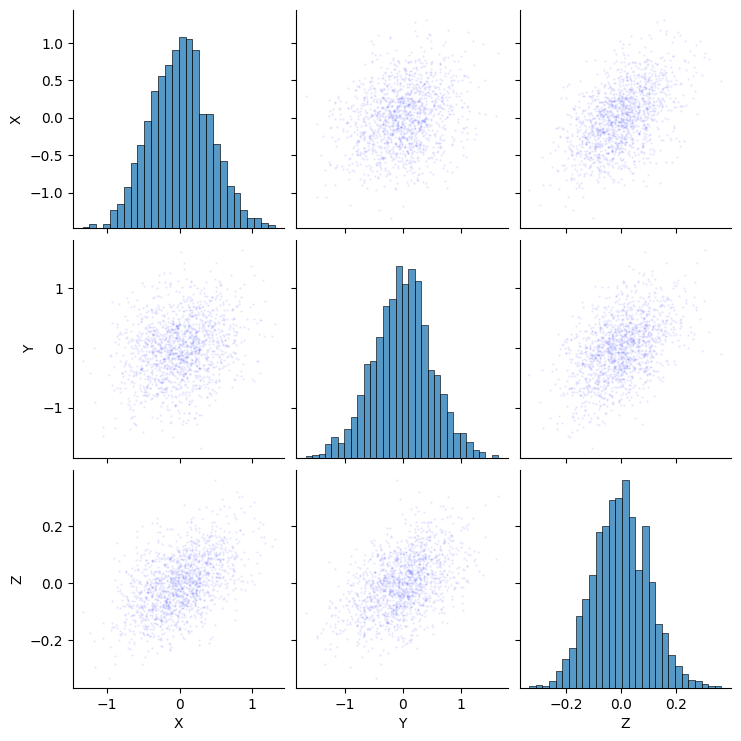

In [14]:
class LinearInstrumentalATE_2SLS(torch.nn.Module):
    def __init__(self, causal_model : Callable, *, num_monte_carlo : int = 1000):
        super().__init__()
        self.model = causal_model
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(Z=(torch.tensor(0.),torch.tensor(1.)))):
                    _, y_all = self.model(*args, **kwargs)
                y_cf_1 = gather(y_all, IndexSet(Z={2}), event_dim=0)
                y_cf_0 = gather(y_all, IndexSet(Z={1}), event_dim=0)

                x_cf_1 = gather(x_all, IndexSet(Z={2}), event_dim=0)
                x_cf_0 = gather(x_all, IndexSet(Z={1}), event_dim=0)
        
        yz = (y_cf_1 - y_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        xz = (x_cf_1 - x_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        ate_2sls = yz / xz
        return pyro.deterministic("2SLS", ate_2sls)
    
ate_2sls = LinearInstrumentalATE_2SLS(PredictiveModel(ReducedObservedBayesianLinearGaussianSCM(len(x_obs)), obs_guide_reduced), num_monte_carlo=5000)()
print(f'Predicted model ATE 2SLS {ate_2sls}')

tr=pyro.poutine.trace(reduced_predictive).get_trace()
x_pred_reduced,y_pred_reduced,z_pred_reduced=[tr.nodes[name]['value'] for name in ['X','Y','Z']]
sns.pairplot(pd.DataFrame({'X':x_pred_reduced.detach().numpy(),'Y':y_pred_reduced.detach().numpy(),'Z':z_pred_reduced.detach().numpy()}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

# 2SLS direct

In [15]:
# linear regression model for Z~X, find the coefficient

beta_lsq = torch.linalg.lstsq(torch.cat((z_obs.unsqueeze(-1),torch.ones_like(z_obs).unsqueeze(-1)),dim=1), x_obs.unsqueeze(-1)).solution[0]

alpha_lsq = torch.linalg.lstsq(torch.cat((beta_lsq*z_obs.unsqueeze(-1),torch.ones_like(z_obs).unsqueeze(-1)),dim=1), y_obs.unsqueeze(-1)).solution[0]

print(f'true: {true_alpha}, estimated: {alpha_lsq}')

true: 1.5, estimated: tensor([1.5113])


In [16]:
alpha_lsq_wrong = torch.linalg.lstsq(torch.cat((x_obs.unsqueeze(-1),torch.ones_like(x_obs).unsqueeze(-1)),dim=1), y_obs.unsqueeze(-1)).solution[0]
print(f'true: {true_alpha}, estimated_naive: {alpha_lsq_wrong}')

true: 1.5, estimated_naive: tensor([1.2379])


# The real two-stage estimator